In [33]:
import sys,os
import uproot4 as uproot
import awkward1 as ak
import json
import numpy as np
import matplotlib.pyplot as plt
from fcc_python_tools.locations import loc
from fcc_python_tools import kinematics_flat
from particle import literals as lp
from fcc_python_tools import plotting
import tensorflow as tf
import zfit
import random
from scipy import stats

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

In [2]:
path = "/eos/experiment/fcc/ee/tmp/testmatching/"
mode = "Bd2DstTauNu"

file = uproot.open(path+f"events_{mode}.root")
tree = file['events']
events = tree.arrays()

n_keep = 10000
events = events[:n_keep]

#Keep the pions
pi_cut = abs(events["RPMC_pdg"]) == abs(lp.pi_plus.pdgid)
events = events[pi_cut]

#Calculate percentage momentum resolution
events["p_res"] = 100*((events["RP_p"] - events["RPMC_p"]) / events["RPMC_p"])

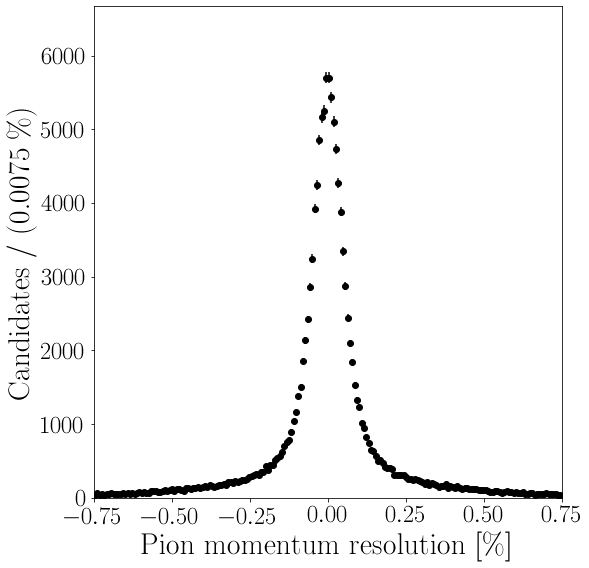

In [7]:
res_lim = 0.75
plotting.errorbar_hist(events,"p_res","pi_p_res","Pion momentum resolution","\\%",-res_lim,res_lim,200)

In [8]:
p_res_cut = abs(events["p_res"]) < res_lim
events = events[p_res_cut]

In [17]:
low = -res_lim
high = res_lim
obs = zfit.Space('pres', limits=(low, high))

#PDF
rand = random.randint(0,999)
mu = zfit.Parameter(f"mu_{rand}", 0., low, high)
sigma = zfit.Parameter(f"sigma_{rand}", 0.05, 0., 0.1)
alphaL = zfit.Parameter(f"alphaL_{rand}", 0.2, 0., 5.)
nL = zfit.Parameter(f"nL_{rand}", 10., 0., 200.)
alphaR = zfit.Parameter(f"alphaR_{rand}", -0.2, -5., 0.)
nR = zfit.Parameter(f"nR_{rand}", 10., 0., 200.)
frac = zfit.Parameter(f"frac_{rand}", 0.5, 0., 1.)

pdf_sigL = zfit.pdf.CrystalBall(obs=obs, mu=mu, sigma=sigma, alpha=alphaL, n=nL)
pdf_sigR = zfit.pdf.CrystalBall(obs=obs, mu=mu, sigma=sigma, alpha=alphaR, n=nR)
pdf = zfit.pdf.SumPDF([pdf_sigL, pdf_sigR], frac)

In [11]:
data_np = ak.to_numpy(ak.flatten(events["p_res"]))
data = zfit.Data.from_numpy(obs=obs, array=data_np)

In [18]:
nll = zfit.loss.UnbinnedNLL(model=pdf, data=data)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll)
param_errors = result.hesse()

print("Fit function minimum:", result.fmin)
print("Fit converged:", result.converged)
print("Fit full minimizer information:", result.info)

params = result.params
print(params)

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -8.135e+04                 │       Ncalls = 452 (452 total)       │
│ EDM = 8e-05 (Goal: 0.001)        │               up = 0.5               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
Fit function minimum: -81348.91189389427
Fit converged: True
Fit full minimizer information: {'n_eval': 452, 'n_iter': 452, 'original': FMin(fval=-81348.91189389427, edm=7.996433043563591e-05, tolerance=1.0, nfcn=452, ncalls=452, up=0.5, is

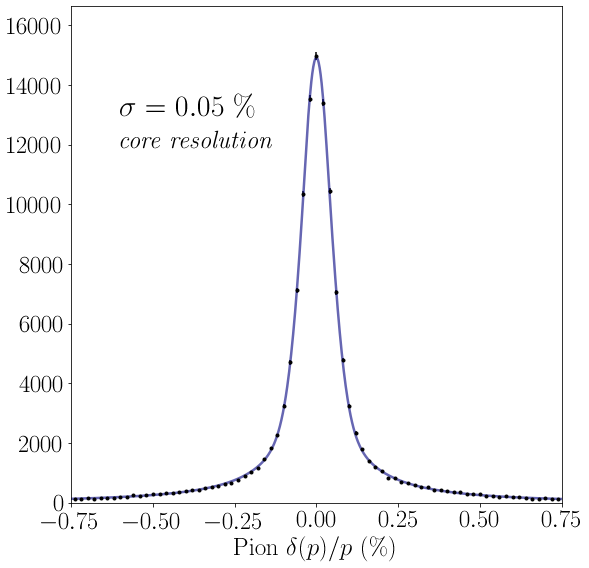

In [29]:
fig,ax = plt.subplots(figsize=(8,8))
lower, upper = obs.limits
low = lower[-1][0]
high = upper[0][0]
bin_width = 0.02
bins = int(float(high - low)/bin_width)
counts, bin_edges = np.histogram(data_np, bins, range=(low,high))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
err = np.sqrt(counts)
plt.errorbar(bin_centres, counts, yerr=err, fmt='o', markersize=3, color='black')
x_plot = np.linspace(low, high, num=1000)
y_plot_tot = zfit.run(pdf.pdf(x_plot, norm_range=obs))
plt.plot(x_plot, y_plot_tot*len(data_np)/bins*obs.area(), color='navy', linewidth=2.5, alpha=0.6)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel("Pion $\delta(p)/p$ ($\\%$)",fontsize=25)
plt.xlim(low,high)
ymin, ymax = plt.ylim()
plt.ylim(0,1.05*ymax)
sigma_val = params[sigma]['value']
plt.text(-0.6,0.82*ymax,"$\\sigma = %.2f$" % sigma_val + " $\\%$",fontsize=30)
plt.text(-0.6,0.75*ymax,"\\textit{core resolution}",fontsize=25)
plt.tight_layout()
fig.savefig(loc.PLOTS+f"/pion_momentum_res_fit.pdf")

In [40]:
n_bin_edges = 15
p_min = 0.5
p_max = 15.
bins = np.linspace(p_min, p_max, n_bin_edges)

delta_p_per_vals = []
delta_p_per_err_vals = []
p_vals = []
for i in range(0,len(bins)-1):
    p_vals.append(bins[i] + 0.5*(bins[i+1] - bins[i]))
    events_bin_cut = np.logical_and(events['RP_p'] >= bins[i], events['RP_p'] < bins[i+1])
    events_bin = events[events_bin_cut]
    delta_p_per_vals.append(np.std(ak.flatten(events_bin["p_res"])))
    delta_p_per_err_vals.append(stats.sem(ak.flatten(events_bin["p_res"])))

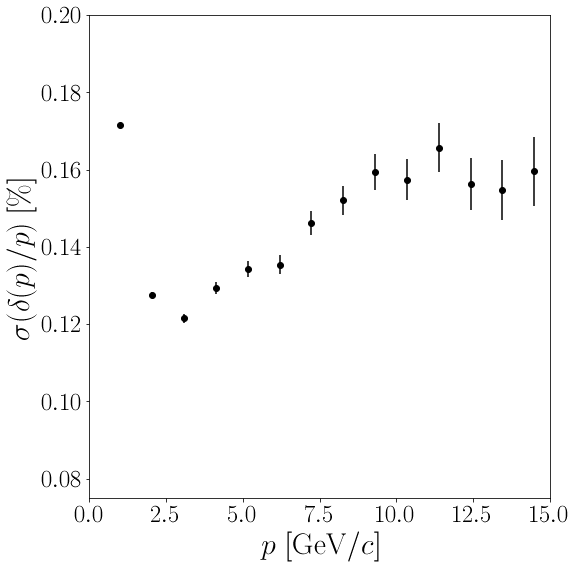

In [41]:
plotting.errorbar_plot(p_vals, 
                       delta_p_per_vals, 
                       "p", 
                       "delta_p_per", 
                       "$p$ [GeV/$c$]", 
                       "$\sigma(\delta(p)/p)$ [$\%$]", 
                       [0.,p_max], 
                       [0.075,0.2], 
                       x_err=None, 
                       y_err=delta_p_per_err_vals)